# Simple linear regression model

In [1]:
import sys
import os

# Adjust the path to point to your project root (the folder containing 'src')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_log_error, make_scorer
from src.preprocessing import clean_data, clean_test_data, build_preprocessor, fit_and_transform_preprocessor
import joblib

In [3]:
# Set paths
DATA_PATH = '../data/raw/train.csv'
PREPROCESSOR_PATH = '../src/preprocessor.pkl'

# Load the data
data = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (750000, 9)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
data.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories'],
      dtype='object')

In [5]:
# Clean data
cleaned_data = clean_data(data)

# Split into training and validation sets
X = data.drop(columns=['id', 'Calories'])
y = data['Calories']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit preprocessor
preprocessor = build_preprocessor(X_train)
X_train_processed, X_val_processed = fit_and_transform_preprocessor(preprocessor, X_train, X_val)

# Save preprocessor
joblib.dump(preprocessor, PREPROCESSOR_PATH)

['../src/preprocessor.pkl']

In [6]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train_processed, y_train)

# Make predictions
y_train_pred = model.predict(X_train_processed)
y_val_pred = model.predict(X_val_processed)

In [7]:
# Clip predictions to ensure they are non-negative
y_train_pred = np.clip(y_train_pred, 0, None)
y_val_pred = np.clip(y_val_pred, 0, None)

In [8]:
# Evaluate the model
train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
val_rmsle = np.sqrt(mean_squared_log_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training RMSLE: {train_rmsle:.4f}")
print(f"Validation RMSLE: {val_rmsle:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")

Training RMSLE: 0.5654
Validation RMSLE: 0.5652
Training R²: 0.9710
Validation R²: 0.9711


In [9]:
# Cross-validation
def safe_msle(y_true, y_pred):
    y_pred = np.clip(y_pred, 0, None)
    return mean_squared_log_error(y_true, y_pred)

rmsle_scorer = make_scorer(safe_msle, greater_is_better=False)
cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring=rmsle_scorer)
cv_rmsle = np.sqrt(-cv_scores.mean())
print(f"5-fold CV RMSLE: {cv_rmsle:.4f}")

5-fold CV RMSLE: 0.5654


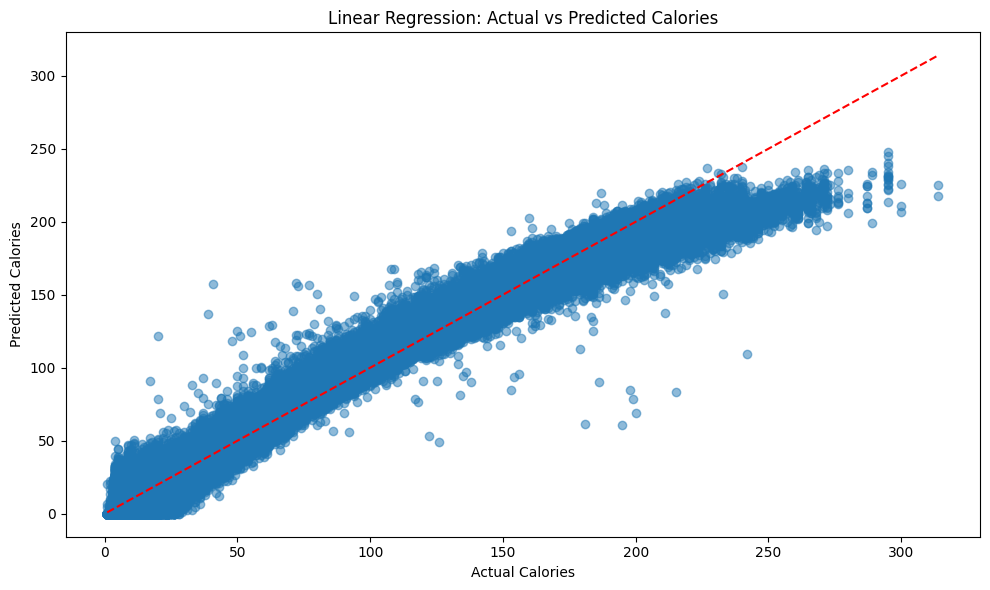

In [10]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.title('Linear Regression: Actual vs Predicted Calories')
plt.tight_layout()
plt.show()

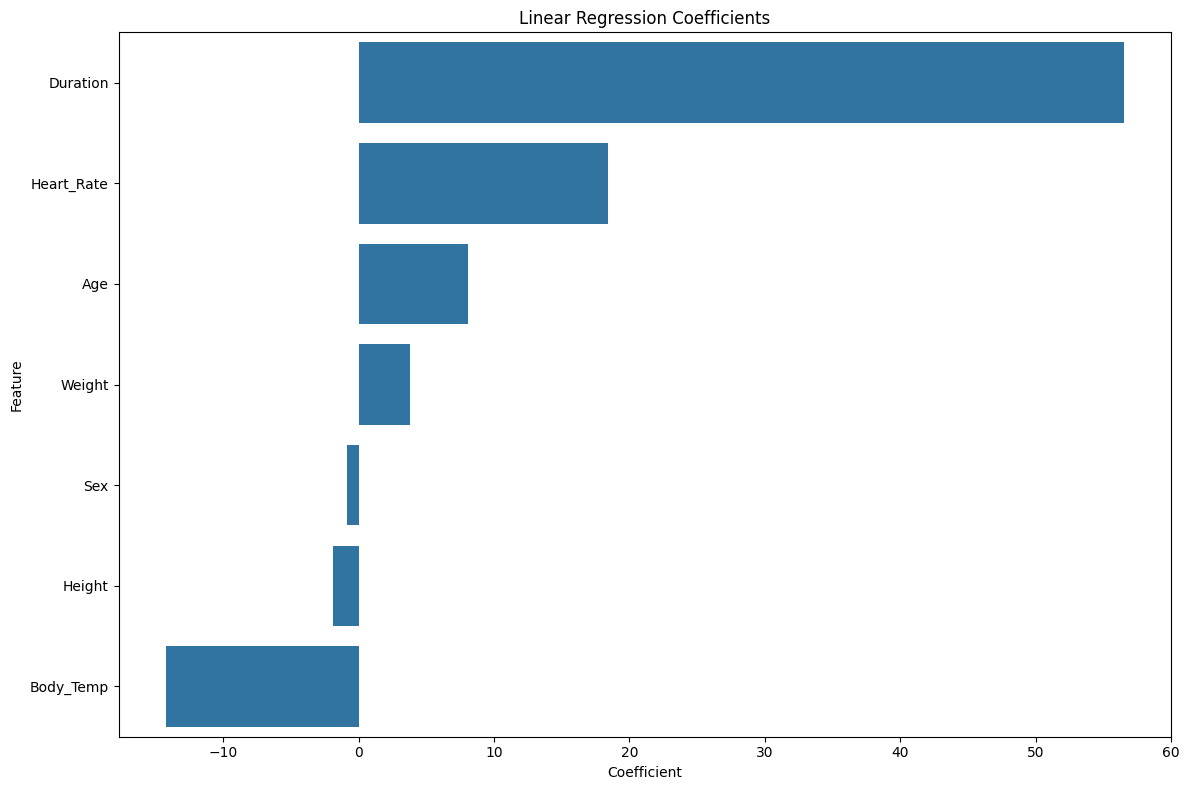

In [11]:
# Feature importance (coefficients)
feature_names = list(X.columns)
for i, encoder in enumerate(preprocessor.transformers_):
    if encoder[0] == 'cat':
        # Get the categorical column names after one-hot encoding
        cat_cols = encoder[2]
        ohe = encoder[1].named_steps['onehot']
        cat_features = []
        for i, col in enumerate(cat_cols):
            cat_features.extend([f"{col}_{c}" for c in ohe.categories_[i]])
        # Replace the original categorical columns with the encoded ones
        for col in cat_cols:
            feature_names.remove(col)
        feature_names.extend(cat_features)

# Plot feature importance
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
})
coef_df = coef_df.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Linear Regression Coefficients')
plt.tight_layout()
plt.show()

In [12]:
# Save the model
joblib.dump(model, '../output/models/linear_regression_model.pkl')
print("Model saved successfully!")

Model saved successfully!


In [13]:
# If you have the feature names after preprocessing:
feature_names = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']  # List of feature names in the same order as model.coef_

equation = f"y = {model.intercept_:.4f}"
for name, coef in zip(feature_names, model.coef_):
    equation += f" + ({coef:.4f} * {name})"
print(equation)

y = 88.2985 + (-0.8440 * Sex) + (8.0789 * Age) + (-1.8817 * Height) + (3.7737 * Weight) + (56.4822 * Duration) + (18.4445 * Heart_Rate) + (-14.1935 * Body_Temp)


In [14]:
# Load the test data
test_data = pd.read_csv('../data/raw/test.csv')

# Clean the test data
cleaned_test_data = clean_test_data(test_data)

# Split into features and target
X_test = cleaned_test_data.drop(columns=['id'])

# Transform the test features using the fitted preprocessor
X_test_processed = preprocessor.transform(X_test)

# 2. Make predictions using the fitted model
y_test_pred = model.predict(X_test_processed)
y_test_pred = np.clip(y_test_pred, 0, None)

In [15]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'Calories': y_test_pred
})
submission.to_csv('../output/submissions/linear_regression.csv', index=False)